In [1]:
%matplotlib inline
import sys
sys.path.append("/home/mette/github/implicitmodules")


# Building more Complex Deformation Modules

In this tutorial, we present the construction of the main deformation modules and display examples of vector fields they can generate.



## Initialization

Import relevant Python modules.




In [2]:
import sys
sys.path.append("../")
import math

import torch
import matplotlib.pyplot as plt

import imodal

imodal.Utilities.set_compute_backend('torch')

torch.manual_seed(1337)

We define a grid on which we compute the generated vector fields.




In [3]:
grid_points = imodal.Utilities.grid2vec(*torch.meshgrid([torch.linspace(-2., 2., 20), torch.linspace(-2., 2., 20)]))

## Sum of Local Translations (unstructured)
We define the parameters, the scale of gaussian kernel **sigma**, **d** the dimension of the ambiant space and **p** the number of local translations (points in the geometrical descriptor).




In [4]:
sigma = 0.5
d = 2
p = 5

There are two ways to build a sum of local translations module, either with **Translations** (explicit formulation) or with **ImplicitModule0** (implicit formulation).
The implicit formulation is a regularised version of the explicit one and depends on a regularization parameter **nu**.




In [5]:
explicit_translation = imodal.DeformationModules.Translations(d, p, sigma)

nu = 0.1
implicit_translation = imodal.DeformationModules.ImplicitModule0(d, p, sigma, nu=nu)

We choose the geometrical descriptor i.e. the centers **gd** carrying the local translations.
Then, we choose the controls **controls** i.e. the translation vectors.




In [6]:
gd = 0.8*torch.randn(p, d)
controls = torch.rand(p, d) - 0.5

explicit_translation.manifold.fill_gd(gd)
implicit_translation.manifold.fill_gd(gd)

explicit_translation.fill_controls(controls)
implicit_translation.fill_controls(controls)

In [7]:
gd, controls

(tensor([[-1.6208, -1.6524],
         [-0.9643, -0.7298],
         [-1.0002,  0.6426],
         [-0.1657,  0.0435],
         [ 0.1103, -0.3111]]),
 tensor([[ 0.3864, -0.1422],
         [ 0.3963,  0.4639],
         [-0.4852,  0.2358],
         [ 0.2884,  0.4469],
         [-0.0344,  0.3378]]))

We compute and display the generated vector fields




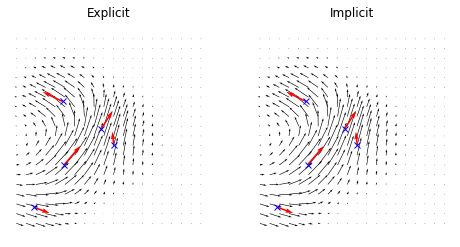

In [8]:
explicit_field = explicit_translation(grid_points)
implicit_field = implicit_translation(grid_points)

plt.figure(figsize=[8., 4.])
plt.subplot(1, 2, 1)
plt.title("Explicit")
plt.quiver(grid_points[:, 0], grid_points[:, 1], explicit_field[:, 0], explicit_field[:, 1])
plt.plot(gd[:, 0], gd[:, 1], 'x', color='blue')
plt.quiver(gd[:, 0], gd[:, 1], controls[:, 0], controls[:, 1], scale=5., color='red', lw=1.5)
plt.axis('equal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Implicit")
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1])
plt.plot(gd[:, 0], gd[:, 1], 'x', color='blue')
plt.quiver(gd[:, 0], gd[:, 1], controls[:, 0], controls[:, 1], scale=5., color='red', lw=1.5)
plt.axis('equal')
plt.axis('off')

plt.show()

## Local Constrained Translations
We build two deformation modules, based on the class **LocalConstrainedTranslation**, generating respectively
one local scaling **local_scaling** and one local rotation **local_rotation**.
We define the parameters, the scale of gaussian kernel **sigma** and **d** the dimension of the ambiant space.




In [9]:
sigma = 1.
d = 2

local_scaling = imodal.DeformationModules.LocalScaling(d, sigma)
local_rotation = imodal.DeformationModules.LocalRotation(d, sigma)

We choose the geometrical descriptor **gd** made of one point and the controls **controls** made of one scalar

<div class="alert alert-info"><h4>Note</h4><p>The control dictate how strong the vector field will be, i.e.
  how much the ambiant space around the gaussian will respectively
  scale or rotate and the direction of the deformation.</p></div>




In [10]:
gd = torch.zeros(1,d)
controls = torch.ones(1)

local_scaling.manifold.fill_gd(gd)
local_rotation.manifold.fill_gd(gd)

local_scaling.fill_controls(controls)
local_rotation.fill_controls(controls)

We compute and display the generated vector fields (**scaling_field** and **rotation_field**) as well as 
the intermediate points and vectors used to build these fields (**support** and **vector**)




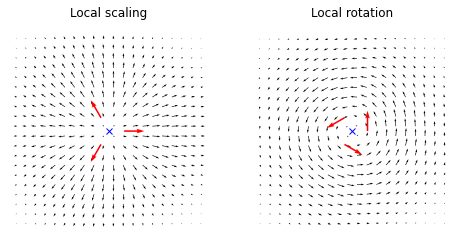

In [11]:
scaling_field = local_scaling(grid_points)
rotation_field = local_rotation(grid_points)

support_scaling = local_scaling._f_support(gd)
vector_scaling = local_scaling._f_vectors(gd)
support_rotation = local_rotation._f_support(gd)
vector_rotation = local_rotation._f_vectors(gd)


plt.figure(figsize=[8., 4.])
plt.subplot(1, 2, 1)
plt.title("Local scaling")
plt.quiver(grid_points[:, 0], grid_points[:, 1], scaling_field[:, 0], scaling_field[:, 1], scale=8.)
plt.plot(gd[:, 0], gd[:, 1], 'x', color='blue')
plt.quiver(support_scaling[:, 0], support_scaling[:, 1], vector_scaling[:, 0], vector_scaling[:, 1], scale=10., color='red', lw=1.5)
plt.axis('equal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Local rotation")
plt.quiver(grid_points[:, 0], grid_points[:, 1], rotation_field[:, 0], rotation_field[:, 1], scale=8.)
plt.plot(gd[:, 0], gd[:, 1], 'x', color='blue')
plt.quiver(support_rotation[:, 0], support_rotation[:, 1], vector_rotation[:, 0], vector_rotation[:, 1], scale=10., color='red', lw=1.5)
plt.axis('equal')
plt.axis('off')

plt.show()

## Implicit Deformation Module of Order 1
We will present here several examples of implicit deformation of order 1 and deformations they can generate.
In all these examples, the dimension of the control is $p=1$.




We define the first parameters: the scale of gaussian kernel **sigma**, the dimension of the ambiant space **d** and the dimension of the control **p**.




In [12]:
sigma = 0.3
d = 2
p = 1
nu = 0.001

We also need to specify the number of points **N** on which the constraints are imposed. We will initially define these constraints on a regular grid **grid_points** and then retrieve the number of points.




In [13]:
positions = torch.load("/home/mette/github/implicitmodules/data/unit_square_points.pt").to(dtype=torch.get_default_dtype())
N = positions.shape[0]

The last parameter to set is the growth model tensor **C**. We recall that, if $h$ is the control, for each $i$ $C_ih$ defines the eigenvalues of the infinitesimal strain tensor of the generated vector field at the $i$-th point of the geometrical descriptor.
We will present 3 different choices for this parameter, corresponding to 3 different constraints.




### Uniform directional scaling

In a first example, we define the growth model tensor **C_directionalscaling** such that it imposes a uniform direction scaling along the first direction of the eigenvector, and no metric change along the second one.




In [14]:
C_directionalscaling = torch.zeros([N, d, p])
C_directionalscaling[:, 0, :] = 1.

We define the corresponding implicit deformation module of order 1 **implicit**.




In [15]:
implicit = imodal.DeformationModules.ImplicitModule1(d, N, sigma, C_directionalscaling, 0.01)

We will present two generated vector field with two initialization of geometrical descriptors.

We choose first the geometrical descriptor **gd** made of **N** points **positions** and **N** rotation matrices **rot** equal to identity.
We recall that these rotation matrices define the eigenvectors of the infinitesimal strain tensor of the generated vector field at each point of the geometrical descriptor.
Then, we choose the controls **controls** made of one scalar.




In [16]:
rot = torch.stack([imodal.Utilities.rot2d(0.)]*positions.shape[0], axis=0)
gd = (positions, rot)

implicit.manifold.fill_gd(gd)

controls = torch.ones(p) 
implicit.fill_controls(controls)

We compute and display the growth factor corresponding to the infinitesimal strain tensor imposed at each point (defined by the eigenvalues and eigenvectors built previously).

There are two ways to display this growth factor:

  i. with oriented arrows along each eigenvector with a length proportional to absolute value of the associated eigenvalue, pointing outward (resp. inward) if it is positive (resp. negative)
  ii. with ellipses whose axis are given by the eigenvectors and the absolute value of the associated eigenvalues.

We then display the generated vector fields (**scaling_field** and **rotation_field**), and the infinitesimal deformation generated by it.




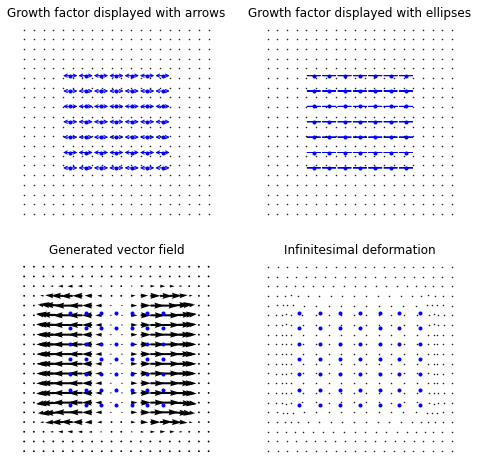

In [17]:
implicit_field = implicit(grid_points)
step = 0.3
new_grid_points = grid_points + step * implicit_field
new_positions = positions + step * implicit(positions)

plt.figure(figsize=[8., 8.])
ax = plt.subplot(2, 2, 1)
plt.title("Growth factor displayed with arrows")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_arrows(ax, positions, C_directionalscaling, R=rot, color='blue', scale=0.4, mutation_scale=8.)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.title("Growth factor displayed with ellipses")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_ellipses(ax, positions, C_directionalscaling, R=rot, color='blue', scale=0.3)
plt.axis('equal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Generated vector field")
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1], scale=10., width=.01)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.title("Infinitesimal deformation")
plt.plot(new_grid_points[:, 0], new_grid_points[:, 1], '.k', markersize=1)
plt.plot(new_positions[:, 0], new_positions[:, 1], '.', color='blue')
plt.axis('equal')
plt.axis('off')

plt.show()

We now choose the **N** rotation matrices **rot** to be equal to the rotation matrix of angle $\pi/2$.




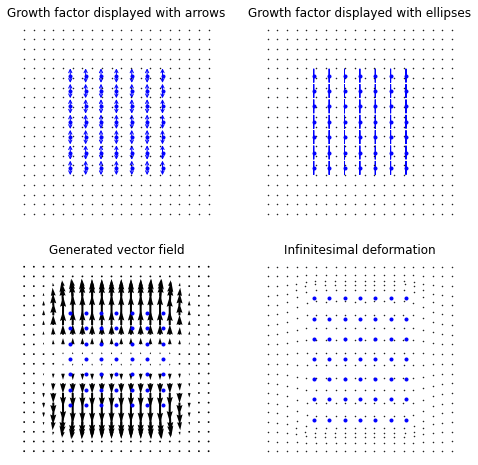

In [18]:
rot = torch.stack([imodal.Utilities.rot2d(0.5 * math.pi)]*positions.shape[0], axis=0)
gd=(positions, rot)

implicit.manifold.fill_gd(gd)

controls = torch.ones(p) 
implicit.fill_controls(controls)

implicit_field = implicit(grid_points)
step = 0.3
new_grid_points = grid_points + step * implicit_field
new_positions = positions + step * implicit(positions)


plt.figure(figsize=[8., 8.])
ax = plt.subplot(2, 2, 1)
plt.title("Growth factor displayed with arrows")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_arrows(ax, positions, C_directionalscaling, R=rot, color='blue', scale=0.4, mutation_scale=8.)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.title("Growth factor displayed with ellipses")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_ellipses(ax, positions, C_directionalscaling, R=rot, color='blue', scale=0.3)
plt.axis('equal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Generated vector field")
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1], scale=10., width=.01)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.title("Infinitesimal deformation")
plt.plot(new_grid_points[:, 0], new_grid_points[:, 1], '.k', markersize=1)
plt.plot(new_positions[:, 0], new_positions[:, 1], '.', color='blue')
plt.axis('equal')
plt.axis('off')
plt.show()

The same result can be obtained with the growth model tensor **C_directionalscaling** imposing a uniform direction scaling along the second direction of the eigenvector, and no metric change along the first one and the N rotation matrices **rot** equal to the identity matrix.




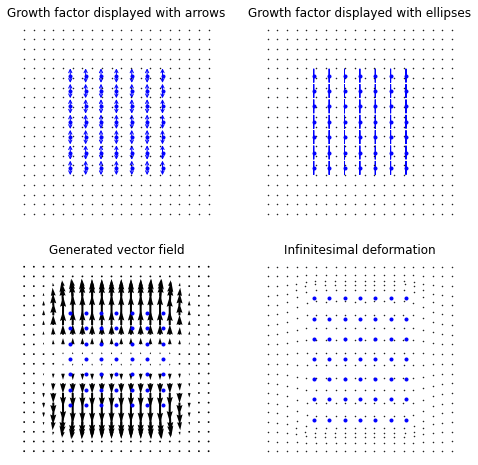

In [19]:
C_directionalscaling = torch.zeros([N, d, p])
C_directionalscaling[:, 1, :] = 1.

implicit = imodal.DeformationModules.ImplicitModule1(d, N, sigma, C_directionalscaling, 0.01)

rot = torch.stack([imodal.Utilities.rot2d(0.)]*positions.shape[0], axis=0)
gd=(positions, rot)

implicit.manifold.fill_gd(gd)

implicit.fill_controls(controls)

implicit_field = implicit(grid_points)
step = 0.3
new_grid_points = grid_points + step * implicit_field
new_positions = positions + step * implicit(positions)


plt.figure(figsize=[8., 8.])
ax = plt.subplot(2, 2, 1)
plt.title("Growth factor displayed with arrows")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_arrows(ax, positions, C_directionalscaling, R=rot, color='blue', scale=0.4, mutation_scale=8.)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.title("Growth factor displayed with ellipses")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_ellipses(ax, positions, C_directionalscaling, R=rot, color='blue', scale=0.3)
plt.axis('equal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Generated vector field")
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1], scale=10., width=.01)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.title("Infinitesimal deformation")
plt.plot(new_grid_points[:, 0], new_grid_points[:, 1], '.k', markersize=1)
plt.plot(new_positions[:, 0], new_positions[:, 1], '.', color='blue')
plt.axis('equal')
plt.axis('off')
plt.show()

### Uniform anisotropic scaling
We define now another implicit deformation module of order 1 generating a uniform scaling twice as important on the first eigenvector than on the second. The growth model tensor **C_anisotropicscaling** is defined as follows.




In [20]:
C_anisotropicscaling = torch.zeros([N, d, p])
C_anisotropicscaling[:, 0, :] = 2.
C_anisotropicscaling[:, 1, :] = 1.

implicit = imodal.DeformationModules.ImplicitModule1(d, N, sigma, C_anisotropicscaling, 0.01)

We choose rotation matrices **rot** to be equal to the rotation matrix of angle $\pi/4$.




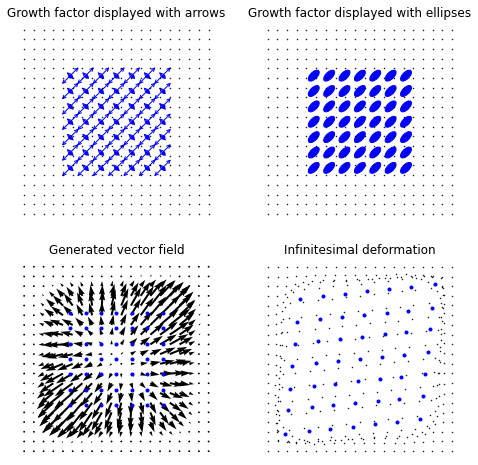

In [21]:
rot = torch.stack([imodal.Utilities.rot2d(math.pi/4.)]*positions.shape[0], axis=0)
gd=(positions, rot)

implicit.manifold.fill_gd(gd)

implicit.fill_controls(controls)

implicit_field = implicit(grid_points)
step = 0.3
new_grid_points = grid_points + step * implicit_field
new_positions = positions + step * implicit(positions)


plt.figure(figsize=[8., 8.])
ax = plt.subplot(2, 2, 1)
plt.title("Growth factor displayed with arrows")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_arrows(ax, positions, C_anisotropicscaling, R=rot, color='blue', scale=0.3, mutation_scale=8.)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.title("Growth factor displayed with ellipses")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_ellipses(ax, positions, C_anisotropicscaling, R=rot, color='blue', scale=0.15)
plt.axis('equal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Generated vector field")
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1], scale=20., width=.01)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.title("Infinitesimal deformation")
plt.plot(new_grid_points[:, 0], new_grid_points[:, 1], '.k', markersize=1)
plt.plot(new_positions[:, 0], new_positions[:, 1], '.', color='blue')
plt.axis('equal')
plt.axis('off')
plt.show()

### Non uniform directional scaling
We present a last another implicit deformation module of order 1 with a non uniform growth model tensor **C_non_unif**. 
It imposes a non uniform scaling on the second eigenvector, with a scaling factor depending on the x-coordinates of the points.
It is defined as follows.




In [22]:
C_non_unif = torch.zeros([N, d, p])
C_non_unif[:, 1, 0] = positions[:,0] + 1.

We define the corresponding implicit deformation module of order 1 **implicit**.




In [23]:
implicit = imodal.DeformationModules.ImplicitModule1(d, N, sigma, C_non_unif, 0.01)

We choose rotation matrices **rot** to be equal to the identity matrix.




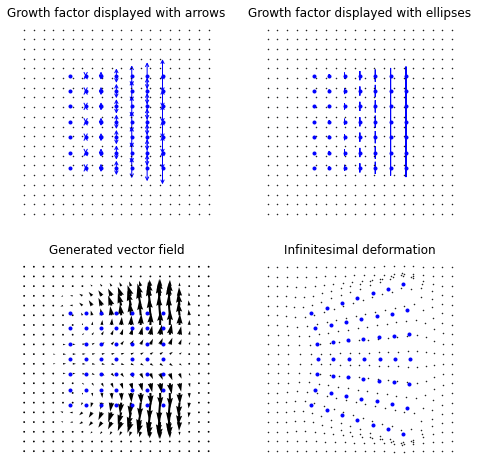

In [24]:
rot = torch.stack([imodal.Utilities.rot2d(0.)]*positions.shape[0], axis=0)
gd=(positions, rot)

implicit.manifold.fill_gd(gd)

implicit.fill_controls(controls)

implicit_field = implicit(grid_points)
step = 0.3
new_grid_points = grid_points + step * implicit_field
new_positions = positions + step * implicit(positions)


plt.figure(figsize=[8., 8.])
ax = plt.subplot(2, 2, 1)
plt.title("Growth factor displayed with arrows")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_arrows(ax, positions, C_non_unif, R=rot, color='blue', scale=0.4, mutation_scale=8.)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 2)
plt.title("Growth factor displayed with ellipses")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_ellipses(ax, positions, C_non_unif, R=rot, color='blue', scale=0.2)
plt.axis('equal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Generated vector field")
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1], scale=20., width=.01)
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(2, 2, 4)
plt.title("Infinitesimal deformation")
plt.plot(new_grid_points[:, 0], new_grid_points[:, 1], '.k', markersize=1)
plt.plot(new_positions[:, 0], new_positions[:, 1], '.', color='blue')
plt.axis('equal')
plt.axis('off')
plt.show()

## Compound Deformation Module
We present an example of the combination **compound** of two deformation modules: the previous implicit deformation module of order one **implicit** (which we rebuild) and one generating one local translation **translation**.
We will show an example of modular large deformation generated by this compound deformation module.




In [25]:
d = 2

sigma_implicit = 0.5
N_implicit = N
p_implicit = 1
nu_implicit = 0.001

rot = torch.stack([imodal.Utilities.rot2d(0.)]*positions.shape[0], axis=0)
C_non_unif = torch.zeros([N, d, p])
C_non_unif[:, 1, 0] = positions[:,0] + 1.
implicit = imodal.DeformationModules.ImplicitModule1(d, N_implicit, sigma_implicit, C_non_unif, 0.01, gd=(positions, rot))
implicit.fill_controls(torch.ones(p_implicit))


sigma_translation = 0.5
N_translation = 1
gd_translation = torch.tensor([[0., 1.]])
translation = imodal.DeformationModules.Translations(d, N_translation, sigma_translation, gd=gd_translation)
control_translation = torch.tensor([[0., 2.]])
translation.fill_controls(control_translation)

compound = imodal.DeformationModules.CompoundModule([implicit, translation])

We display the growth factor and the translation vector.
We then display the generated vector fields (**scaling_field** and **rotation_field**), and the infinitesimal deformation generated by it.




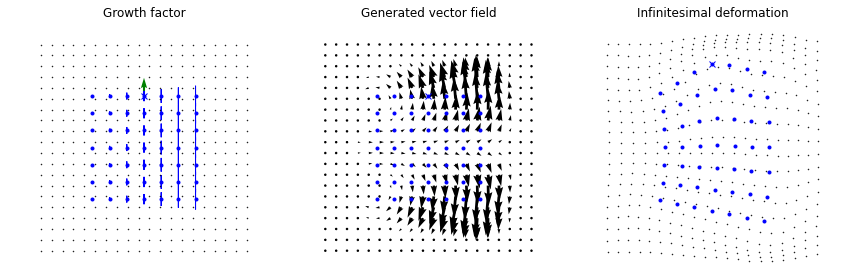

In [26]:
compound_field = compound(grid_points)
step = 0.2
new_grid_points = grid_points + step * compound_field
new_positions = positions + step * compound(positions)
new_gd_translation = gd_translation + step * compound(gd_translation)


fig = plt.figure(figsize=[12., 4.])
ax = plt.subplot(1, 3, 1)
plt.title("Growth factor")
plt.plot(grid_points[:, 0], grid_points[:, 1], '.k', markersize=1)
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
imodal.Utilities.plot_C_ellipses(ax, positions, C_non_unif, R=rot, color='blue', scale=0.2)
plt.plot(gd_translation[:,0], gd_translation[:,1], 'xb')
plt.quiver(gd_translation[:,0], gd_translation[:,1], control_translation[:,0], control_translation[:,1], color='green', scale=30.)
plt.axis('equal')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated vector field")
plt.plot(positions[:, 0], positions[:, 1], '.', color='blue')
plt.quiver(grid_points[:, 0], grid_points[:, 1], implicit_field[:, 0], implicit_field[:, 1], scale=20., width=.01)
plt.plot(gd_translation[:,0], gd_translation[:,1], 'xb')
plt.axis('equal')
plt.axis('off')

ax = plt.subplot(1, 3, 3)
plt.title("Infinitesimal deformation")
plt.plot(new_grid_points[:, 0], new_grid_points[:, 1], '.k', markersize=1)
plt.plot(new_positions[:, 0], new_positions[:, 1], '.', color='blue')
plt.plot(new_gd_translation[:,0], new_gd_translation[:,1], 'xb')
plt.axis('equal')
plt.axis('off')

fig.tight_layout()
plt.show()

In order to better understand this compound module, we present a modular large deformation generated by it.
It is parametrized by an initial momentum which we set to zero except for **cotan_translation** associated to the local translation and **cotan_implicit_points** associated to the points of the geometrical descriptor of the implicit deformation module.




In [27]:
cotan_translation = torch.tensor([[0., 1.]])
translation.manifold.fill_cotan(cotan_translation)

cotan_implicit_points = torch.zeros_like(positions)
cotan_implicit_points[0,1] = -5.
implicit.manifold.fill_cotan((cotan_implicit_points, torch.zeros_like(rot)))

In order to keep track of the grid deformation, we define a silent deformation module **silent** whose points are the grid points. It is built from the class **SilentLandmarks**.




In [28]:
silent = imodal.DeformationModules.SilentLandmarks(dim=2, nb_pts=grid_points.shape[0], gd=grid_points.clone())

We solve the shooting equations. 




In [29]:
shoot_method = 'euler'
shoot_it = 10
intermediates = {}
imodal.HamiltonianDynamic.shoot(imodal.HamiltonianDynamic.Hamiltonian([silent, implicit, translation]), shoot_method, shoot_it, intermediates=intermediates)

We display the deformed points, the vector of the translation and the growth factor at each time. 
Note that the growth model tensor **C_non_unif** is a fixed parameter that does not evolve during the integration of the flow but that the growth factor (constraining the infinitesimal strain tensor and illustrated by the blue ellipses) built from **C_non_unif**,  the control **control_translation_t** and the rotation matrices **rot_t** do evolve.




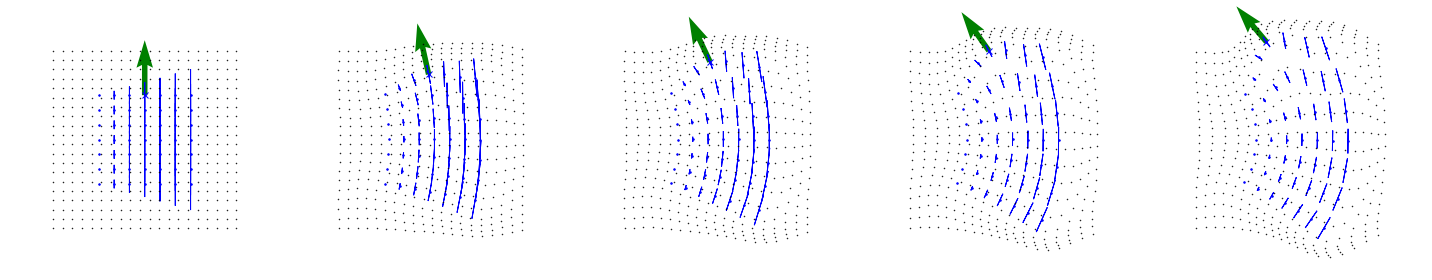

In [30]:
display_index = [0, 3, 5, 7, 9]
aabb = imodal.Utilities.AABB.build_from_points(grid_points).scale(1.5)

fig = plt.figure(figsize=[20., 4.])
for count, i in enumerate(display_index):
    ax = plt.subplot(1, 5, count+1)
    grid_points_t = intermediates['states'][i][0].gd.detach()
    positions_t = intermediates['states'][i][1].gd[0].detach()
    control_implicit_t = intermediates['controls'][i][1].detach()
    rot_t = intermediates['states'][i][1].gd[1].detach()
    gd_translation_t = intermediates['states'][i][2].gd.detach()
    control_translation_t = intermediates['controls'][i][2].detach()
    plt.plot(grid_points_t[:, 0], grid_points_t[:, 1], '.k', markersize=1)
    plt.plot(positions_t[:, 0], positions_t[:, 1], '.', color='blue', markersize=3)
    imodal.Utilities.plot_C_ellipses(ax, positions_t, control_implicit_t*C_non_unif, R=rot_t, color='blue', scale=1.)
    plt.plot(gd_translation_t[:,0], gd_translation_t[:,1], 'xb')
    plt.quiver(gd_translation_t[:,0], gd_translation_t[:,1], control_translation_t[:,0], control_translation_t[:,1], color='green', scale=5., width=.02)
    # plt.axis('equal')
    plt.axis(aabb.totuple())
    plt.axis('off')

fig.tight_layout()
plt.show()